In [1]:
import ctypes
import matplotlib.pyplot as plt

ASSET_CORR = 0.25
CUT_OFF = -0.5
EAD = 1
LGD = 0.6
PF_SIZE = 100
N_SIMS = 10_000

In [2]:
class Config(ctypes.Structure):
    _fields_ = [
        ("asset_corr", ctypes.c_float),
        ("cut_off", ctypes.c_float),
        ("EAD", ctypes.c_float),
        ("LGD", ctypes.c_float),
        ("pf_size", ctypes.c_int),
        ("n_sims", ctypes.c_int),
        ("L_PF", ctypes.POINTER(ctypes.c_float))
    ]

class Result(ctypes.Structure):
    _fields_ = [
        ("L_PF", ctypes.POINTER(ctypes.c_float))
    ]

libmonte = ctypes.CDLL("./libmerton.so")
libmonte.simulate.argtypes = [Config]
libmonte.simulate.restype = Result

In [3]:
config = Config(ASSET_CORR, CUT_OFF, EAD, LGD, PF_SIZE, N_SIMS)
result = libmonte.simulate(config)
l_pf = [float(result.L_PF[i]) for i in range(N_SIMS)]

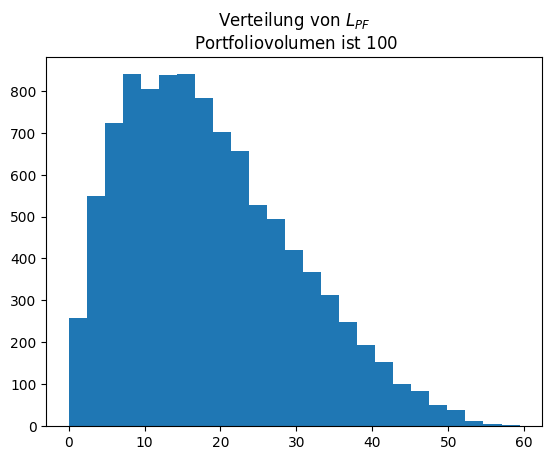

In [4]:
fig, ax = plt.subplots()
ax.set_title(f"Verteilung von $L_{{PF}}$ \n Portfoliovolumen ist ${PF_SIZE*EAD}$")

ax.hist(l_pf, bins=25)
plt.show()